# Term Paper 2 - Visualizations

## Importing Libraries, Data and setting up

In [1]:
import os
import yaml
import xarray as xr
import rioxarray as rio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import mode

from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

import warnings

# Filter RuntimeWarning with the specific message
warnings.filterwarnings(
    "ignore",  # Action: ignore the warning
    category=RuntimeWarning,  # Type of warning
    message="invalid value encountered in cast"  # Specific message to match
)


In [2]:
# paths
with open('../path_config.yaml', 'r') as file:
    paths = yaml.safe_load(file)
paths = {key: Path(value) for key, value in paths.items()}

with open(paths['plot_config_path'], 'r') as file:
    plot_config = yaml.safe_load(file)

# coordinates
csr = 'EPSG:2056'

# filter warnings
warnings.filterwarnings("ignore", message="angle from rectified to skew grid parameter lost in conversion to CF")


In [3]:
def create_run_path_dict(run_path: str, only_completly_traind: bool=True) -> dict:
    """
    creating dictionary with paths to data for a specific run

    Parameters:
        run_path (str): Path to folder containing the output folders for a series of models.
        data_type (str): Data type ('predictions', 'metrics', 'config').

    Returns:
        a dictionay with the models as keys containing a dictionary with the data types as keys and the paths as values.

        {"model1": {"predictions": path, "metrics": path, "config": path},
    """
    run_path = Path(run_path)

    # get all models
    models = {}
    for subfolder in run_path.iterdir():
        include = False
        if (subfolder / 'config.yaml').exists():
            include = True
            if only_completly_traind:
                #check if "preds.zarr" exists
                if not (subfolder / 'preds.zarr').exists():
                    include = False
        
        if include:
            models[subfolder.name] = {
                'predictions': subfolder / 'preds.zarr',
                'metrics': subfolder / 'metrics.csv',
                'config': subfolder / 'config.yaml'
            }

    return models

# function to load data path from run
def run_data_path(run: str, data_type: str) -> Path:
    """
    getting run data path

    Parameters:
        run (str): Run name.
        data_type (str): Data type ('predictions', 'metrics', 'config').

    Returns:
        path (Path): Path to the run data.
    """

    if data_type == 'predictions':
        target = 'preds.zarr'
    elif data_type == 'metrics':
        target = 'metrics.csv'
    elif data_type == 'config':
        target = 'config.yaml'
    else:
        raise ValueError('Invalid data type. Choose from: "predictions", "metrics", "config".')

    return paths['output_path'] / run / target
    
# function to reduce plotting resolution
def mode_reduction(block, axis):
        # Flatten the block and calculate the mode
        dim0, dim1, dim2, dim3 = block.shape
        flattened = block.transpose((0, 2, 1, 3)).reshape(dim0, dim2, -1)
        result = mode(flattened, axis=-1, nan_policy='omit').mode
        return result

def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    if reduction == 'mode':
        return da.coarsen(x=factor, y=factor, boundary="trim").reduce(mode_reduction).compute()
    else:
        return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

# function to smooth metrics
def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def calculate_normalized_rgb(
    rs: xr.Dataset, 
    gamma: float = 1.0, 
    clip_min: float = 0.0, 
    clip_max: float = 1.0
) -> np.ndarray:
    """
    Calculate normalized RGB from an xarray Dataset with optional scaling, gamma correction, and clipping.

    Parameters:
        ds (xr.Dataset): Input dataset containing the bands with dimensions [4, 'x', 'y'].
        gamma (float): Gamma correction factor. Default is 1.0 (no gamma correction).
        clip_min (float): Minimum value for clipping. Default is 0.0.
        clip_max (float): Maximum value for clipping. Default is 1.0.

    Returns:
        np.ndarray: Normalized RGB image as a NumPy array with shape (H, W, 3) and values in [0, 1].
    """
    # Mask zero values with NaN to avoid skewing normalization
    ds = rs.where(rs > 0)

    # Select the respective bands
    red_band = ds.sel(band=2)
    green_band = ds.sel(band=3)
    blue_band = ds.sel(band=4)

    # Scale values to [0, 1] range before any processing
    def scale_to_unit(array):
        return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

    red_scaled = scale_to_unit(red_band)
    green_scaled = scale_to_unit(green_band)
    blue_scaled = scale_to_unit(blue_band)

    # Function to normalize an array with clipping
    def normalize(array):
        # Clip values to specified range
        clipped = np.clip(array, clip_min, clip_max)
        # Normalize to [0, 1]
        return (clipped - np.nanmin(clipped)) / (np.nanmax(clipped) - np.nanmin(clipped))

    # Normalize each band with scaling, clipping, and gamma correction
    red_normalized = normalize(np.power(red_scaled, gamma))
    green_normalized = normalize(np.power(green_scaled, gamma))
    blue_normalized = normalize(np.power(blue_scaled, gamma))

    # Stack bands into an RGB array
    rgb = np.dstack((red_normalized, green_normalized, blue_normalized))

    return rgb

def plot_settings(label_type: str):
    """
    Get plot settings for the specified label type.

    Parameters:
        label_type (str): Label type ('category', 'sealed', 'sealed_simple').

    Returns:
        legend_elements (list): List of legend elements.
        class_cmap (ListedColormap): Colormap for the classes.
        class_norm (BoundaryNorm): Boundary norm for the classes.

    """

    if label_type == 'category':
        class_info = plot_config['class_info_category']
    
    elif label_type == 'sealed':
        class_info = plot_config['class_info_sealed']

    elif label_type == 'sealed_simple':
        class_info = plot_config['class_info_sealed']
        class_info = {key: value for key, value in class_info.items() if key != 2}

    else:
        raise ValueError('Invalid label type. Choose from: "category", "sealed", "sealed_simple".')

    sorted_classes = sorted(class_info.keys())
    colors = [class_info[key][1] for key in sorted_classes]

    class_cmap = ListedColormap(colors)
    bounds = list(sorted_classes) + [sorted_classes[-1] + 1]
    class_norm = BoundaryNorm(bounds, class_cmap.N)

    diff_info = plot_config['diff_info']

    sorted_classes_diff = sorted(diff_info.keys())
    colors_diff = [diff_info[key][1] for key in sorted_classes_diff]
    diff_cmap = ListedColormap(colors_diff)


    legend_info = {**class_info, **diff_info}
    legend_elements = [Patch(facecolor=legend_info[key][1], label=legend_info[key][0]) for key in sorted(legend_info.keys())]

    return legend_elements, class_cmap, class_norm, diff_cmap

## Visualizations of the available Data

### Size of the 3 areas

In [4]:
# import .shp file
gdf = gpd.read_file(paths['shp_labels'])

# group df by area and summarize Shape_Area by sum
gdf_grouped = gdf.groupby('area').agg({'Shape_Area': 'sum'}).reset_index()
gdf_grouped


,area,Shape_Area
0,industrial,132641.574903
1,residential,83487.396389
2,rural,82739.756797


### Available data per label

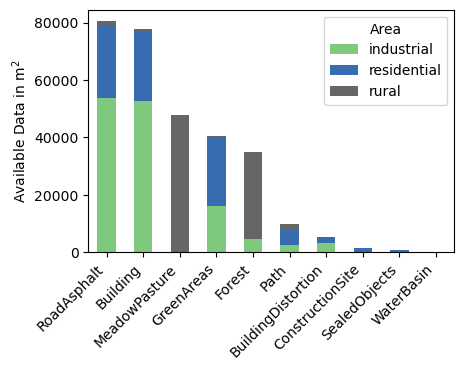

In [5]:
fig_filename = 'area_by_category.pdf'
image_size_cm = [12, 8]

fig, ax = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Aggregate the grouped data
data = gdf.groupby(['QA_categor', 'area'])['Shape_Area'].sum().unstack().fillna(0)

# Sort the data by the total size of each QA_categor
data['Total'] = data.sum(axis=1)
data = data.sort_values('Total', ascending=False).drop(columns='Total')

# Plot stacked bar chart
data.plot(kind='bar', stacked=True, ax=ax, colormap='Accent')

ax.set_xlabel(None)
ax.set_ylabel('Available Data in m$^2$')
ax.legend(title='Area')

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig(paths["figure_output_path"] / fig_filename, bbox_inches='tight')
plt.show()


## Visualizations of the Results

### Loss and accuracy

In [6]:
def plot_metrics(
        model_dict: dict,
        title: str=None,
        type: str='valid', 
        step: bool=False, 
        image_size_cm: list[int,int]=[14,7], 
        window_size: int=5
        ):

    """
    Plot the training and validation metrics of a run.

    Parameters:

        run (str): Run name.
        type (str): Type of metrics ('train', 'valid'). Default is 'valid'.
        step (bool): for type 'train', plot step instead of epoch. Default is False.
        image_size_cm (list): Size of the output image in cm.
        window_size (int): Size of the smoothing window. Default is 5.

    """
    metrics = pd.read_csv(model_dict['metrics'])

    if type == 'valid':
        loss = 'valid_loss'
        acc = 'valid_acc'
        label = ['Validation Loss', 'Validation Accuracy']
    elif type == 'train':
        label = ['Training Loss', 'Training Accuracy']
        if step:
            loss = 'train_loss_step'
            acc = 'train_acc_step'
        else:
            loss = 'train_loss_epoch'
            acc = 'train_acc_epoch'

    validation_data = metrics[~metrics[loss].isnull()]

    # Smooth the data
    smoothed_val_loss = smooth_data(validation_data[loss], window_size=window_size)
    smoothed_val_acc = smooth_data(validation_data[acc], window_size=window_size)

    # Adjust the epoch range to match the length of the smoothed data
    epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

    fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

    plt.title(title)

    # Plot unsmoothed valid_loss on the primary y-axis
    ax1.plot(validation_data['epoch'], validation_data[loss], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
    # Plot smoothed valid_loss on the primary y-axis
    ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label=label[0], linewidth=0.5)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(label[0])
    ax1.tick_params(axis='y')

    # Create a secondary y-axis to plot valid_acc
    ax2 = ax1.twinx()
    # Plot unsmoothed valid_acc on the secondary y-axis
    ax2.plot(validation_data['epoch'], validation_data[acc], color='#FB9A99', label='', linewidth=1, alpha=0.5)
    # Plot smoothed valid_acc on the secondary y-axis
    ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label=label[0], linewidth=0.5)
    ax2.set_ylabel(label[1])
    ax2.tick_params(axis='y')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.18), ncol=2)

    fig.tight_layout()
    plt.show()
    
    return fig


### Visualizations of the Predictions

In [7]:
def plot_run_visual(model_dict: dict, title: str=None, image_size_cm: list[int,int]=[16, 22]):
    """
    Plot the visual predictions for a given run.

    Parameters:
        run (str): path relative to run folder.
        image_size_cm (list): Image size in cm default is [16, 22].

    """
    config_path = model_dict['config']
    prediction_path = model_dict['predictions']

    plot_suptitle = title # if None, no suptitle is added

    titles_views = ["RGB", "Labels", "Predictions", "Difference"]

    area_labels = [4, 8, 12]


    # loading run config
    with open(config_path, 'r') as file:
        model_config = yaml.safe_load(file)

    label_type = model_config['label_type']

    # load areas
    areas = gpd.read_file(paths['shp_aoi'])

    # load training data
    ds_data_raw = xr.open_zarr(paths['data_path']).rio.write_crs(csr)

    rs = ds_data_raw['rs']

    label = ds_data_raw[label_type]
    label = label.where(label != 255, np.nan)

    # load predictions
    predictions = xr.open_zarr(prediction_path).rio.write_crs(csr)['label_pred']

    rgb_list = []
    label_list = []
    pred_list = []
    diff_list = []

    for area_label in area_labels:

        clip_feature = areas[areas['DataLabel'] == area_label]

        rs_clipped = rs.rio.clip(clip_feature.geometry, clip_feature.crs)
        label_clipped = label.rio.clip(clip_feature.geometry, clip_feature.crs)
        pred_clipped = predictions.rio.clip(clip_feature.geometry, clip_feature.crs)

        rgb_norm_settings = plot_config['rgb_norm_settings'][f'{area_label}']
        rgb = calculate_normalized_rgb(rs = rs_clipped, **rgb_norm_settings)

        rgb_transposed = rgb.transpose((1, 0, 2))

        label_transposed = label_clipped.transpose('y', 'x')
        pred_transposed = pred_clipped.transpose('y', 'x')

        difference = label_transposed - pred_transposed
        difference_std = xr.where(np.isnan(difference), np.nan, xr.where(difference == 0, 0, 1))

        rgb_list.append(rgb_transposed)
        label_list.append(label_transposed)
        pred_list.append(pred_transposed)
        diff_list.append(difference_std)

    # loading plot settings
    legend_elements, class_cmap, class_norm, diff_cmap = plot_settings(label_type)

    # Create GridSpec layout with 5 rows and 4 columns
    fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
    gs = GridSpec(6, 4, width_ratios=[0.05, 1, 1, 1], height_ratios=[0.05, 1, 1, 1, 1, 0.5], figure=fig)

    if plot_suptitle is not None:
        fig.suptitle(plot_suptitle, fontsize=12)

    # Add rotated titles to the first column (col 0)
    for i, title in enumerate(titles_views):
        ax_title = fig.add_subplot(gs[i+1, 0])  # Create an axis in the (i, 0) position
        ax_title.text(0.5, 0.5, title, fontsize=10, va='center', ha='center', rotation=90)
        ax_title.axis('off')  # Turn off the axis

    # # Add colorbar axis
    legend_ax = fig.add_subplot(gs[5, 0:5])
    legend_ax.axis('off')
    legend_ax.legend(
        handles=legend_elements,
        loc='center',
        frameon=False,
        ncol=3,  # Number of columns for the legend items
        bbox_to_anchor=(0.5, 0.5),  # Center the legend in the axis
        fontsize=8,  # Smaller font size
        columnspacing=0.5,  # Reduce space between columns
        handletextpad=0.3,  # Reduce space between handles and labels
        borderpad=0.2,  # Reduce padding inside the legend box
        labelspacing=0.2  # Reduce vertical space between labels
    )

    for i, area_label in enumerate(area_labels):

        # add a title for the row
        ax_title = fig.add_subplot(gs[0, i+1])
        ax_title.text(0.5, 0.5, f'Area {area_label}', fontsize=10, va='center', ha='center')
        ax_title.axis('off')

        # plottin RGB
        
        ax_rgb = fig.add_subplot(gs[1, i+1])
        ax_rgb.imshow(rgb_list[i])
        ax_rgb.axis('off')

        # Plotting labels
        
        ax_labels = fig.add_subplot(gs[2, i+1])
        ax_labels.imshow(label_list[i], cmap=class_cmap, norm=class_norm, interpolation="nearest")
        ax_labels.axis('off')

        # Plotting predictions
        
        ax_predictions = fig.add_subplot(gs[3, i+1])
        ax_predictions.imshow(pred_list[i], cmap=class_cmap, norm=class_norm, interpolation="nearest")
        ax_predictions.axis('off')

        # Plotting difference
        
        ax_difference = fig.add_subplot(gs[4, i+1])
        ax_difference.imshow(diff_list[i], cmap=diff_cmap, interpolation="nearest")
        ax_difference.axis('off')


    plt.subplots_adjust(
        hspace=0.1,  # Adjust vertical spacing
        wspace=0.1   # Adjust horizontal spacing
    )

    fig.tight_layout()

    plt.show()

    return fig
    

In [8]:
def plot_all_models(models: dict, save_path: str=None):

    if save_path is not None:

        save_path = Path(save_path)

        if not save_path.exists():
            save_path.mkdir(parents=True)
        else:
            raise ValueError(f"Path {save_path} already exists.")

    num_models = len(models)
    counter = 1

    for key, value in models.items():
        print(f"Plotting model {counter} of {num_models}")
        visual = plot_run_visual(model_dict=value, title=key)
        metric = plot_metrics(model_dict=value, title=key, type='valid', step=True)

        counter += 1

        if save_path is not None:
            visual.savefig(save_path / f'{key}_visual.pdf')
            metric.savefig(save_path / f'{key}_metric.pdf')

In [9]:
run_path = paths['output_path'] / "sealed_simple"
out_path = run_path / "plots"

models = create_run_path_dict(run_path, only_completly_traind=True)

Plotting model 1 of 8


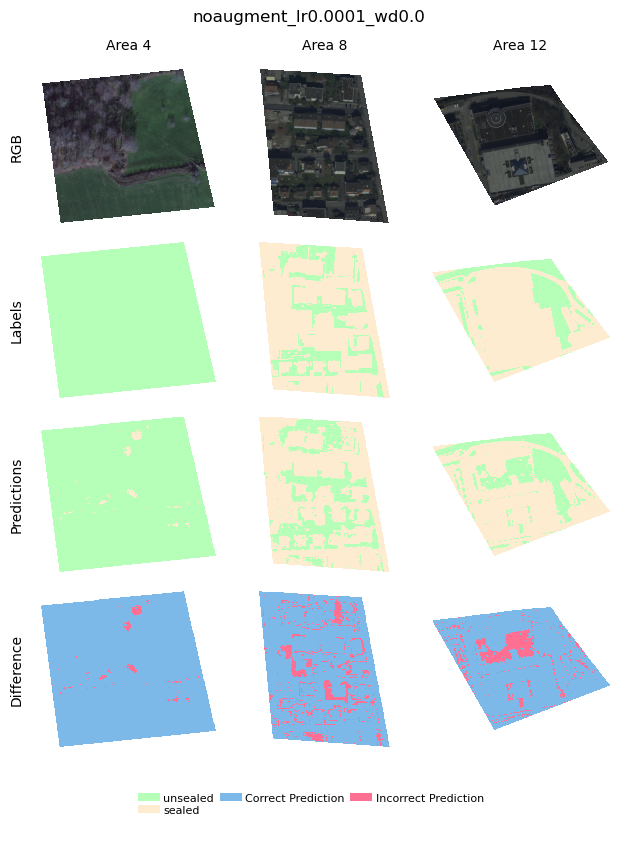

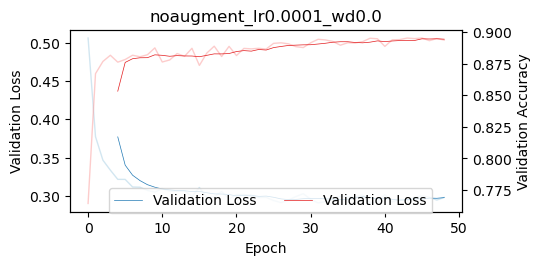

Plotting model 2 of 8


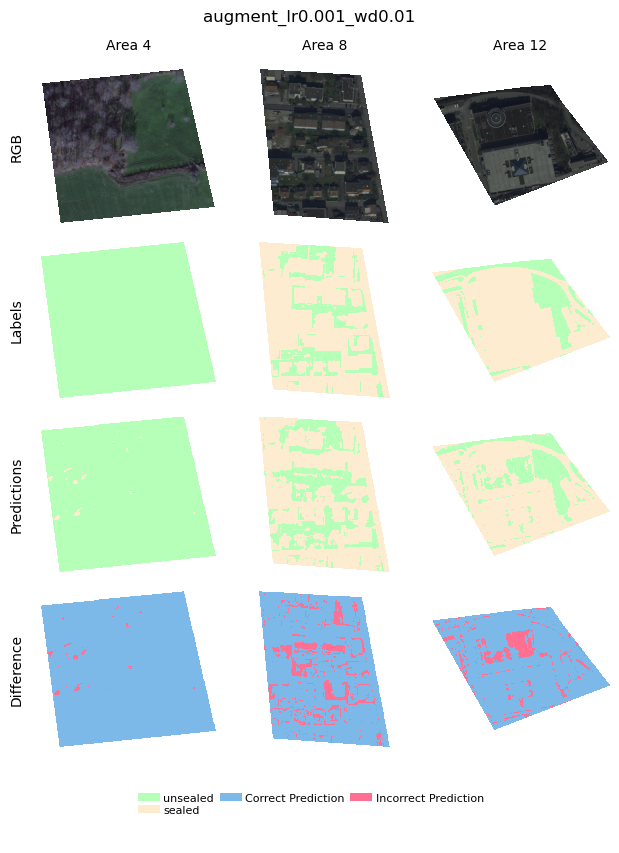

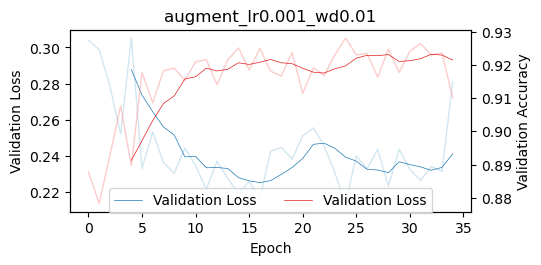

Plotting model 3 of 8


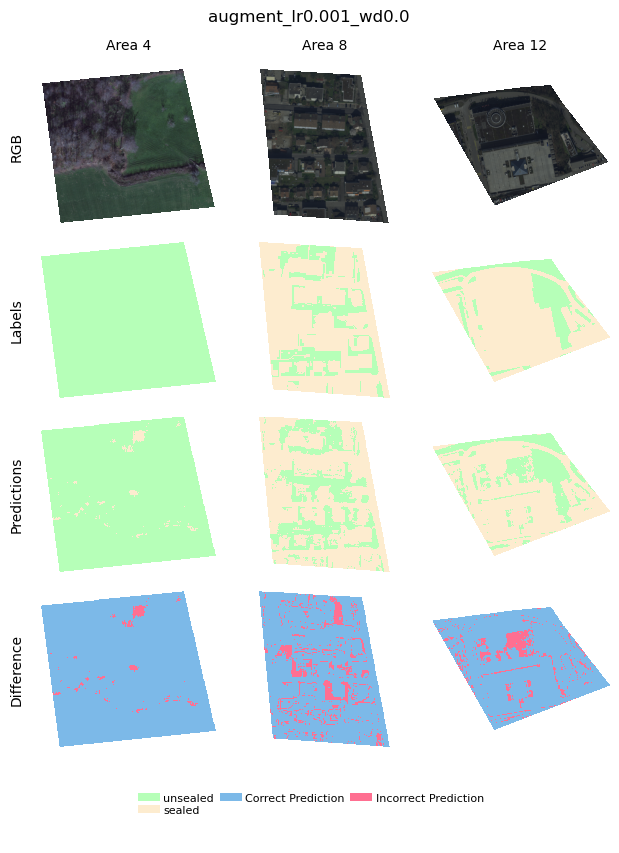

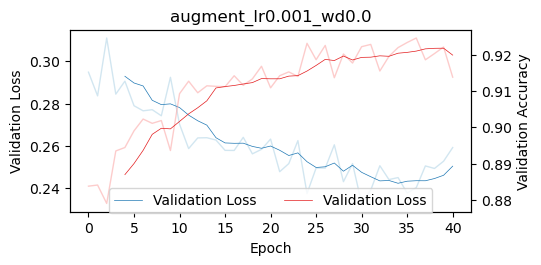

Plotting model 4 of 8


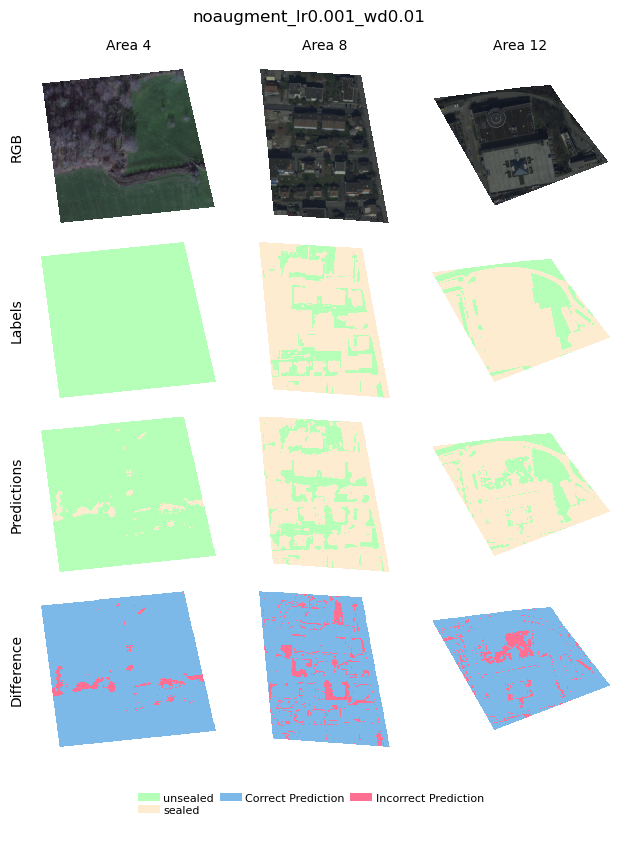

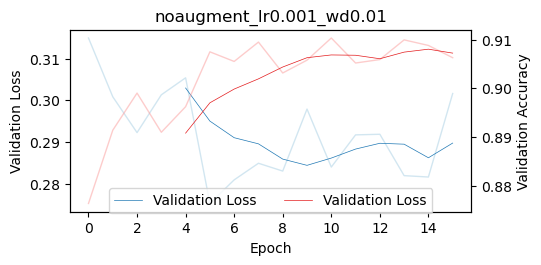

Plotting model 5 of 8


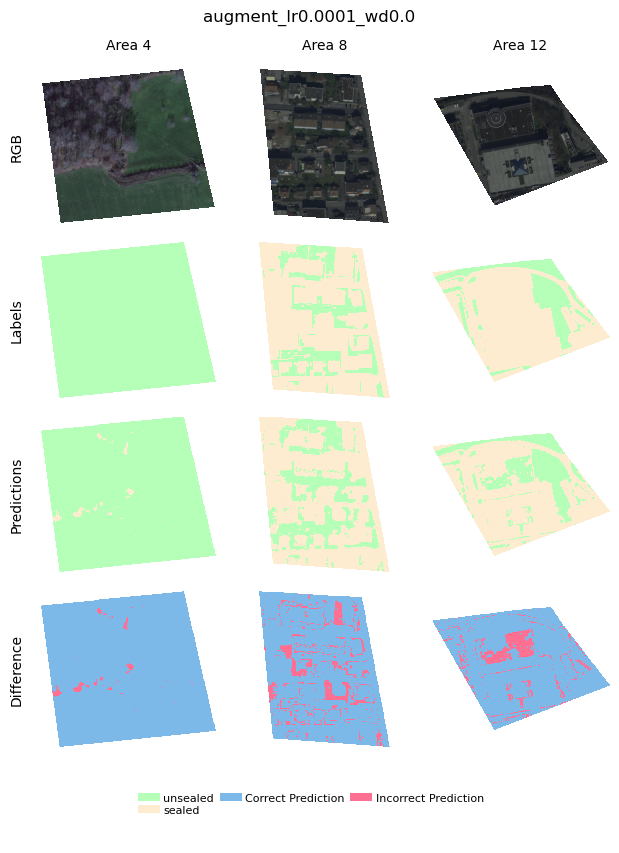

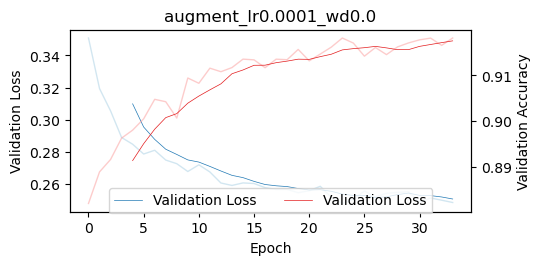

Plotting model 6 of 8


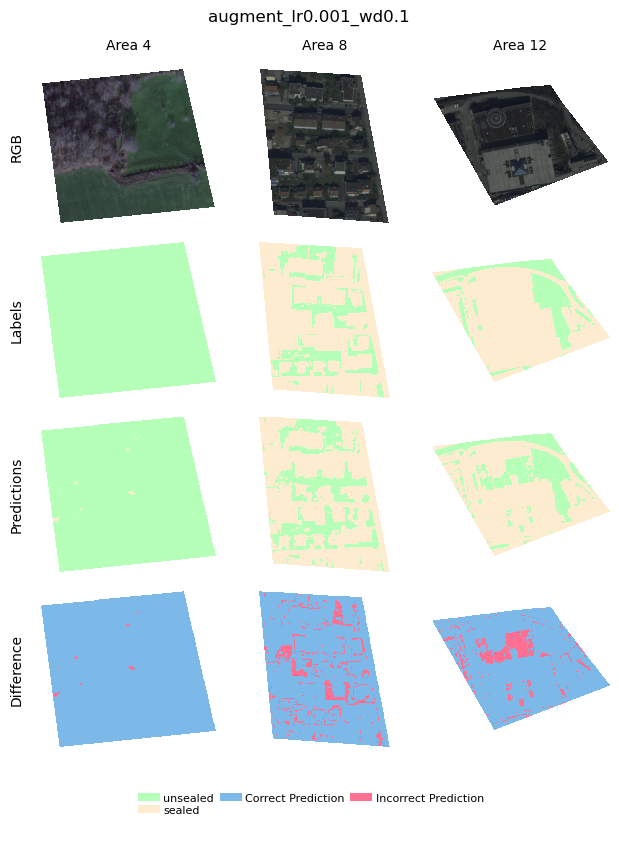

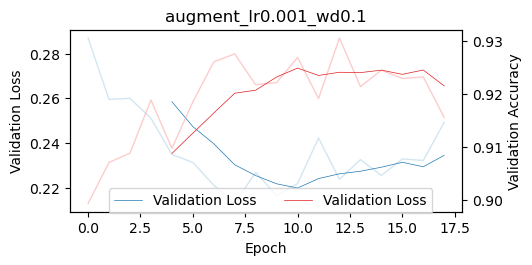

Plotting model 7 of 8


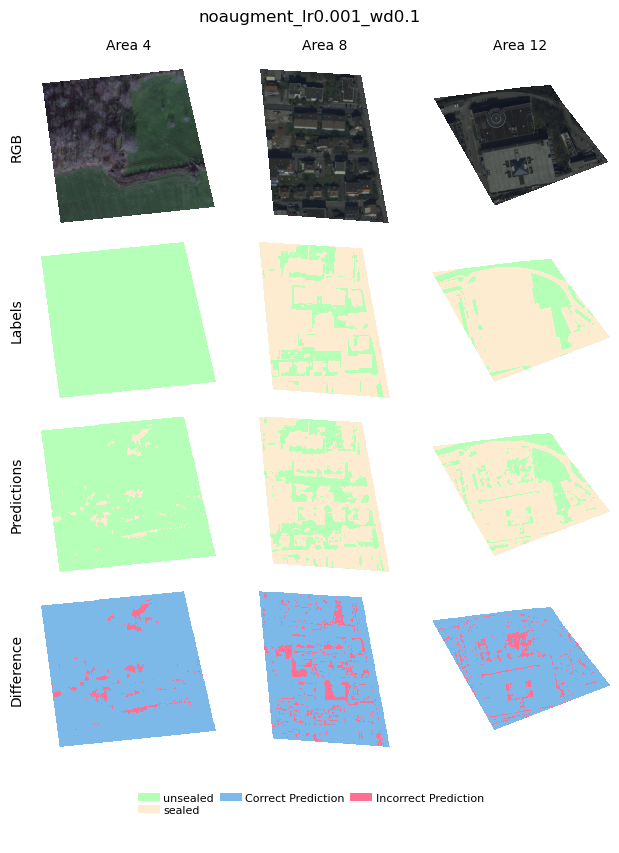

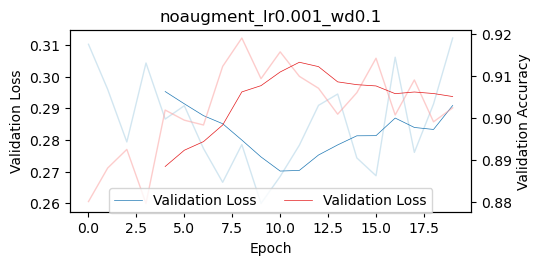

Plotting model 8 of 8


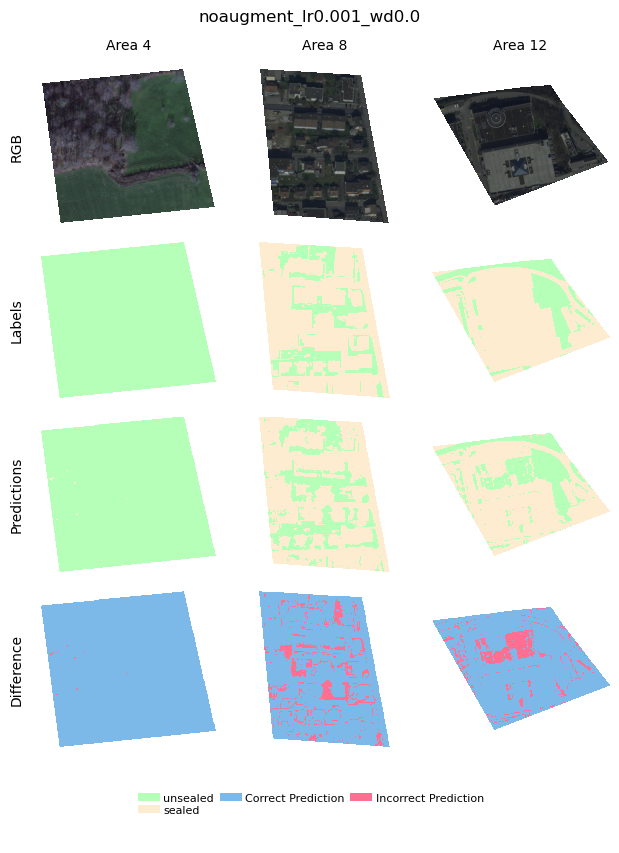

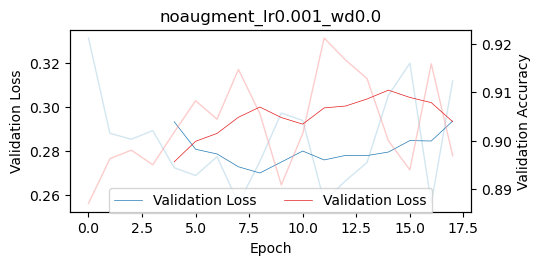

In [11]:
plot_all_models(models, save_path=out_path)